In [1]:
%cd ../AlphaPose

C:\Users\Jellyfish\diplom_data\AlphaPose


Halpe первые 26 ключевых точек:
//26 body keypoints
    {0,  "Nose"},
    {1,  "LEye"},
    {2,  "REye"},
    {3,  "LEar"},
    {4,  "REar"},
    {5,  "LShoulder"},
    {6,  "RShoulder"},
    {7,  "LElbow"},
    {8,  "RElbow"},
    {9,  "LWrist"},
    {10, "RWrist"},
    {11, "LHip"},
    {12, "RHip"},
    {13, "LKnee"},
    {14, "Rknee"},
    {15, "LAnkle"},
    {16, "RAnkle"},
    {17,  "Head"},
    {18,  "Neck"},
    {19,  "Hip"},
    {20, "LBigToe"},
    {21, "RBigToe"},
    {22, "LSmallToe"},
    {23, "RSmallToe"},
    {24, "LHeel"},
    {25, "RHeel"},

In [2]:
HALPE_JOINTS_ID = {0:"Nose", 1:"LEye", 2:"REye", 3:"LEar", 4:"REar",
                   5:"LShoulder", 6:"RShoulder", 7:"LElbow", 8:"RElbow",
                   9:"LWrist", 10:"RWrist", 11:"LHip", 12:"RHip",
                   13:"LKnee", 14:"Rknee", 15:"LAnkle", 16:"RAnkle",
                   17:"Head", 18:"Neck", 19:"Hip", 20:"LBigToe",
                   21:"RBigToe", 22:"LSmallToe", 23:"RSmallToe", 
                   24:"LHeel", 25:"RHeel"}

Из файла scripts/demo_inference.py

In [3]:
import os
import trackers
import detector
import alphapose 

In [4]:
"""Script for single-gpu/multi-gpu demo."""
import argparse
import os
import platform
import sys
import time
import json

import numpy as np
import torch
from tqdm import tqdm
import natsort
import cv2 as cv
import matplotlib.pyplot as plt

from detector.apis import get_detector
from trackers.tracker_api import Tracker
from trackers.tracker_cfg import cfg as tcfg
from trackers import track
from alphapose.models import builder
from alphapose.utils.config import update_config
from alphapose.utils.detector import DetectionLoader
from alphapose.utils.file_detector import FileDetectionLoader
from alphapose.utils.transforms import flip, flip_heatmap
from alphapose.utils.vis import getTime
from alphapose.utils.webcam_detector import WebCamDetectionLoader
from alphapose.utils.writer import DataWriter

"""----------------------------- Demo options -----------------------------"""
def get_parser():
    parser = argparse.ArgumentParser(description='AlphaPose Demo')
    parser.add_argument('--cfg', type=str, required=True,
                        help='experiment configure file name')
    parser.add_argument('--checkpoint', type=str, required=True,
                        help='checkpoint file name')
    parser.add_argument('--sp', default=False, action='store_true',
                        help='Use single process for pytorch')
    parser.add_argument('--detector', dest='detector',
                        help='detector name', default="yolo")
    parser.add_argument('--detfile', dest='detfile',
                        help='detection result file', default="")
    parser.add_argument('--indir', dest='inputpath',
                        help='image-directory', default="")
    parser.add_argument('--list', dest='inputlist',
                        help='image-list', default="")
    parser.add_argument('--image', dest='inputimg',
                        help='image-name', default="")
    parser.add_argument('--outdir', dest='outputpath',
                        help='output-directory', default="examples/res/")
    parser.add_argument('--save_img', default=False, action='store_true',
                        help='save result as image')
    parser.add_argument('--vis', default=False, action='store_true',
                        help='visualize image')
    parser.add_argument('--showbox', default=False, action='store_true',
                        help='visualize human bbox')
    parser.add_argument('--profile', default=False, action='store_true',
                        help='add speed profiling at screen output')
    parser.add_argument('--format', type=str,
                        help='save in the format of cmu or coco or openpose, option: coco/cmu/open')
    parser.add_argument('--min_box_area', type=int, default=0,
                        help='min box area to filter out')
    parser.add_argument('--detbatch', type=int, default=5,
                        help='detection batch size PER GPU')
    parser.add_argument('--posebatch', type=int, default=64,
                        help='pose estimation maximum batch size PER GPU')
    parser.add_argument('--eval', dest='eval', default=False, action='store_true',
                        help='save the result json as coco format, using image index(int) instead of image name(str)')
    parser.add_argument('--gpus', type=str, dest='gpus', default="0",
                        help='choose which cuda device to use by index and input comma to use multi gpus, e.g. 0,1,2,3. (input -1 for cpu only)')
    parser.add_argument('--qsize', type=int, dest='qsize', default=1024,
                        help='the length of result buffer, where reducing it will lower requirement of cpu memory')
    parser.add_argument('--flip', default=False, action='store_true',
                        help='enable flip testing')
    parser.add_argument('--debug', default=False, action='store_true',
                        help='print detail information')
    """----------------------------- Video options -----------------------------"""
    parser.add_argument('--video', dest='video',
                        help='video-name', default="")
    parser.add_argument('--webcam', dest='webcam', type=int,
                        help='webcam number', default=-1)
    parser.add_argument('--save_video', dest='save_video',
                        help='whether to save rendered video', default=False, action='store_true')
    parser.add_argument('--vis_fast', dest='vis_fast',
                        help='use fast rendering', action='store_true', default=False)
    """----------------------------- Tracking options -----------------------------"""
    parser.add_argument('--pose_flow', dest='pose_flow',
                        help='track humans in video with PoseFlow', action='store_true', default=False)
    parser.add_argument('--pose_track', dest='pose_track',
                        help='track humans in video with reid', action='store_true', default=False)
    return parser 
    
def check_input(args):
    # for wecam
    if args.webcam != -1:
        args.detbatch = 1
        return 'webcam', int(args.webcam)

    # for video
    if len(args.video):
        if os.path.isfile(args.video):
            videofile = args.video
            return 'video', videofile
        else:
            raise IOError('Error: --video must refer to a video file, not directory.')

    # for detection results
    if len(args.detfile):
        if os.path.isfile(args.detfile):
            detfile = args.detfile
            return 'detfile', detfile
        else:
            raise IOError('Error: --detfile must refer to a detection json file, not directory.')

    # for images
    if len(args.inputpath) or len(args.inputlist) or len(args.inputimg):
        inputpath = args.inputpath
        inputlist = args.inputlist
        inputimg = args.inputimg

        if len(inputlist):
            im_names = open(inputlist, 'r').readlines()
        elif len(inputpath) and inputpath != '/':
            for root, dirs, files in os.walk(inputpath):
                im_names = files
            im_names = natsort.natsorted(im_names)
        elif len(inputimg):
            args.inputpath = os.path.split(inputimg)[0]
            im_names = [os.path.split(inputimg)[1]]

        return 'image', im_names

    else:
        raise NotImplementedError
        
def print_finish_info(args):
    print('===========================> Finish Model Running.')
    if (args.save_img or args.save_video) and not args.vis_fast:
        print('===========================> Rendering remaining images in the queue...')
        print('===========================> If this step takes too long, you can enable the --vis_fast flag to use fast rendering (real-time).')

def loop():
    n = 0
    while True:
        yield n
        n += 1

2024-03-27 14:52:16 [DEBUG]: Loaded backend agg version v2.2.


In [ ]:
parser = get_parser()
args = parser.parse_args([
    "--cfg", os.path.join("configs", "halpe_26", "resnet", "256x192_res50_lr1e-3_1x.yaml"),
    "--checkpoint", os.path.join("pretrained_models", "halpe26_fast_res50_256x192.pth"),
    '--sp',
    "--gpus", "0",
    #"--image", "../test_frame.jpg", # change
    "--video", "../original_vids/20240320_193441-30fps.mp4",
    "--profile",
    "--qsize", "1",
    "--outdir", "../alphapose_res", # for testing only
    "--format", "coco",
    '--eval'
])
args.gpus = [int(i) for i in args.gpus.split(',')] if torch.cuda.device_count() >= 1 else [-1]
args.device = torch.device("cuda:" + str(args.gpus[0]) if args.gpus[0] >= 0 else "cpu")
args.detbatch = args.detbatch * len(args.gpus)
args.posebatch = args.posebatch * len(args.gpus)
args.tracking = args.pose_track or args.pose_flow or args.detector=='tracker'
cfg = update_config(args.cfg)
mode, input_source = check_input(args)

if not os.path.exists(args.outputpath):
    os.makedirs(args.outputpath)

# Load detection loader
if mode == 'webcam':
    det_loader = WebCamDetectionLoader(input_source, get_detector(args), cfg, args)
    det_worker = det_loader.start()
elif mode == 'detfile':
    det_loader = FileDetectionLoader(input_source, cfg, args)
    det_worker = det_loader.start()
else:
    det_loader = DetectionLoader(input_source, get_detector(args), cfg, args, batchSize=args.detbatch, mode=mode, queueSize=args.qsize)
    det_worker = det_loader.start()

# Load pose model
pose_model = builder.build_sppe(cfg.MODEL, preset_cfg=cfg.DATA_PRESET)

print('Loading pose model from %s...' % (args.checkpoint,))
pose_model.load_state_dict(torch.load(args.checkpoint, map_location=args.device))
pose_dataset = builder.retrieve_dataset(cfg.DATASET.TRAIN)
if args.pose_track:
    tracker = Tracker(tcfg, args)
if len(args.gpus) > 1:
    pose_model = torch.nn.DataParallel(pose_model, device_ids=args.gpus).to(args.device)
else:
    pose_model.to(args.device)
pose_model.eval();

In [6]:
# Init data writer
queueSize = 2 if mode == 'webcam' else args.qsize
if args.save_video and mode != 'image':
    from alphapose.utils.writer import DEFAULT_VIDEO_SAVE_OPT as video_save_opt
    if mode == 'video':
        video_save_opt['savepath'] = os.path.join(args.outputpath, 'AlphaPose_' + os.path.basename(input_source))
    else:
        video_save_opt['savepath'] = os.path.join(args.outputpath, 'AlphaPose_webcam' + str(input_source) + '.mp4')
    video_save_opt.update(det_loader.videoinfo)
    writer = DataWriter(cfg, args, save_video=True, video_save_opt=video_save_opt, queueSize=queueSize).start()
else:
    writer = DataWriter(cfg, args, save_video=False, queueSize=queueSize).start()

if mode == 'webcam':
    print('Starting webcam demo, press Ctrl + C to terminate...')
    sys.stdout.flush()
    im_names_desc = tqdm(loop())
else:
    data_len = det_loader.length
    im_names_desc = tqdm(range(data_len), dynamic_ncols=True)

runtime_profile = {
    'dt': [],
    'pt': [],
    'pn': []
}

batchSize = args.posebatch
if args.flip:
    batchSize = int(batchSize / 2)
try:
    for i in im_names_desc:
        start_time = getTime()
        with torch.no_grad():
            (inps, orig_img, im_name, boxes, scores, ids, cropped_boxes) = det_loader.read()
            if orig_img is None:
                break
            if boxes is None or boxes.nelement() == 0:
                writer.save(None, None, None, None, None, orig_img, im_name)
                continue
            if args.profile:
                ckpt_time, det_time = getTime(start_time)
                runtime_profile['dt'].append(det_time)
            # Pose Estimation
            inps = inps.to(args.device)
            datalen = inps.size(0)
            leftover = 0
            if (datalen) % batchSize:
                leftover = 1
            num_batches = datalen // batchSize + leftover
            hm = []
            for j in range(num_batches):
                inps_j = inps[j * batchSize:min((j + 1) * batchSize, datalen)]
                if args.flip:
                    inps_j = torch.cat((inps_j, flip(inps_j)))
                hm_j = pose_model(inps_j)
                if args.flip:
                    hm_j_flip = flip_heatmap(hm_j[int(len(hm_j) / 2):], pose_dataset.joint_pairs, shift=True)
                    hm_j = (hm_j[0:int(len(hm_j) / 2)] + hm_j_flip) / 2
                hm.append(hm_j)
            hm = torch.cat(hm)
            if args.profile:
                ckpt_time, pose_time = getTime(ckpt_time)
                runtime_profile['pt'].append(pose_time)
            if args.pose_track:
                boxes,scores,ids,hm,cropped_boxes = track(tracker,args,orig_img,inps,boxes,hm,cropped_boxes,im_name,scores)
            hm = hm.cpu()
            writer.save(boxes, scores, ids, hm, cropped_boxes, orig_img, im_name)
            if args.profile:
                ckpt_time, post_time = getTime(ckpt_time)
                runtime_profile['pn'].append(post_time)

        if args.profile:
            # TQDM
            im_names_desc.set_description(
                'det time: {dt:.4f} | pose time: {pt:.4f} | post processing: {pn:.4f}'.format(
                    dt=np.mean(runtime_profile['dt']), pt=np.mean(runtime_profile['pt']), pn=np.mean(runtime_profile['pn']))
            )
    print_finish_info(args)
    while(writer.running()):
        time.sleep(1)
        print('===========================> Rendering remaining ' + str(writer.count()) + ' images in the queue...', end='\r')
    writer.stop()
    det_loader.stop()
except Exception as e:
    print(repr(e))
    print('An error as above occurs when processing the images, please check it')
    pass
except KeyboardInterrupt:
    print_finish_info(args)
    # Thread won't be killed when press Ctrl+C
    if args.sp:
        det_loader.terminate()
        while(writer.running()):
            time.sleep(1)
            print('===========================> Rendering remaining ' + str(writer.count()) + ' images in the queue...', end='\r')
        writer.stop()
    else:
        # subprocesses are killed, manually clear queues
        det_loader.terminate()
        writer.terminate()
        writer.clear_queues()
        det_loader.clear_queues()
#print(inps, orig_img, im_name, boxes, scores, ids, cropped_boxes)

det time: 0.0304 | pose time: 0.0185 | post processing: 0.0378: 100%|██████████████| 6258/6258 [09:16<00:00, 11.24it/s]


===========================> Finish Model Running.
Results have been written to json.


In [82]:
def plot_joint_coords_chart(title:str, joint_dynamic:np.array, jindices:list=None):
    all_joints_coords = joint_dynamic #(33, frame count, 3)
    x_data = np.arange(all_joints_coords.shape[1])
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(15, 10))
    color_step = 255 / all_joints_coords.shape[0]
    for i in range(all_joints_coords.shape[0]):
        if jindices and not (i in jindices):
            continue
        clr = color_step * i / 255
        axs[0].plot(x_data, all_joints_coords[i, :, 0], color=(clr, 0, 0))
        axs[1].plot(x_data, all_joints_coords[i, :, 1], color=(0, clr, 0))
        axs[2].plot(x_data, all_joints_coords[i, :, 2], color=(0, 0, clr))
    axs[0].set_title(title)
    plt.show()

#### Для всех графиков упражнений координата X отображается красным, Y - зеленым, confidence для данной точки - голубым

#### Все координаты в плоскости изображения. Начало - левый верхний угол.

# Анализ видео одного человека с одним упражнением

In [7]:
def parse_annotation_to_array(name):
    with open(name, "r") as res_file:
        kp_res = json.load(res_file)
    # for vid with 1 human
    kp_byframes = []
    for i in range(26): # 26 joints total
        kp_byframes.append([])
    prev_img_id = -1
    for frame_info in kp_res:
        if frame_info['image_id'] > prev_img_id:
            frame_kps = frame_info['keypoints']
            joint_idx = 0
            for jstart_idx in range(0, len(frame_kps), 3):
                coords = [frame_kps[jstart_idx], frame_kps[jstart_idx+1], frame_kps[jstart_idx+2]]
                kp_byframes[joint_idx].append(coords)
                joint_idx += 1
            prev_img_id = frame_info['image_id']
    return np.array(kp_byframes)
    
def plot_joints_from_json(name, plot_title):
    joint_coords = parse_annotation_to_array(name)
    plot_joint_coords_chart(plot_title, joint_coords)

In [10]:
# for one exercise
exercise = "utmt"
data_files = []
for filen in os.listdir("../alphapose_res/stud_videos_processed"):
    if exercise in filen:        
        data_files.append(filen)
len(data_files)

14

In [11]:
formatter = lambda n: "{:>4}".format(n)
for fname in data_files:
    with open(os.path.join("../alphapose_res/stud_videos_processed", fname), "r") as res_file:
        kps_info = json.load(res_file)
    all_frame_ids = [f["image_id"] for f in kps_info]
    uniq_frames, people_count = np.unique(all_frame_ids, return_counts=True)
    uniq_people_count, in_frames = np.unique(people_count, return_counts=True)
    print(fname.split('.')[0], "people count and frame count in which this many were detected:")
    pcounts = ", ".join(list(map(formatter, uniq_people_count)))
    fcounts = ", ".join(list(map(formatter, in_frames)))
    print("Count of people", pcounts)
    print("Count of frames", fcounts)

utmt_00 people count and frame count in which this many were detected:
Count of people    1,    2,    3,    4,    5,    6,    7
Count of frames    2,  185,  662,  450,  169,   37,    5
utmt_01 people count and frame count in which this many were detected:
Count of people    1,    2,    3,    4,    5,    6,    7,    8
Count of frames   52,  190,  450,  488,  270,   49,   10,    1
utmt_02 people count and frame count in which this many were detected:
Count of people    3,    4,    5,    6,    7
Count of frames  529,  550,  334,   95,    2
utmt_03 people count and frame count in which this many were detected:
Count of people    1,    2,    3,    4,    5,    6
Count of frames  381,  643,  371,   97,   14,    4
utmt_04 people count and frame count in which this many were detected:
Count of people    2,    3,    4,    5,    6
Count of frames  610,  729,  147,   21,    3
utmt_05 people count and frame count in which this many were detected:
Count of people    2,    3,    4,    5,    6
Count o

# Resample (OK!)

In [48]:
# пусть будем брать фиксированной длины
TOTAL_KP_COUNT = 256 # power of 2
def resample_to_frame_length(keypoints:np.array, new_length:int):
    """ Assumes keypoints.shape = (n joints, n frames, n coords).
        Returned shape = (n joints, new_length, n coords).
    """
    if keypoints.shape[1] == new_length: # nothing to change
        return keypoints
    if keypoints.shape[1] < new_length: # append 0
        add_frames = new_length - keypoints.shape[1]
        addition = np.zeros((keypoints.shape[0], add_frames, keypoints.shape[2]),
                           dtype=keypoints.dtype)
        return np.concatenate((keypoints, addition), 1)        
    # n frames > new_length
    picked_frame_idx = np.linspace(0, keypoints.shape[1] + 1, new_length, 
                                   endpoint=False, dtype=np.int64)    
    return np.copy(keypoints[:, picked_frame_idx, :])

In [45]:
# test resampling on real data
long_exerc_fname = "../alphapose_res/irimi_tenkan_tenkai_side_ref.json" # 311 frames
short_exerc_fname = "../alphapose_res/tenkai_side_ref.json" # 90 frames
import io
# try to make animation
def animate_keypoints(joints:np.array, filename:str):
    fig = plt.figure(figsize=(12.8, 7.2))
    fig.tight_layout(pad=0)    
    ax = fig.add_subplot()
    w, h = fig.canvas.get_width_height()
    w = int(w)
    h = int(h)
    xmin, xmax = np.min(joints[:, :, 0]), np.max(joints[:, :, 0])
    ymin, ymax = np.min(joints[:, :, 1]), np.max(joints[:, :, 1])
    
    codec_code = cv.VideoWriter.fourcc(*'mp4v')
    writer = cv.VideoWriter(filename, codec_code, 30.0, (w, h))
    print("writer opened:", writer.isOpened())
    
    for frame in tqdm(range(joints.shape[1])):
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        
        ax.scatter(joints[:, frame, 0], joints[:, frame, 1])
        # joint connections
        ax.plot(joints[[4, 2, 0, 1, 3], frame, 0], joints[[4, 2, 0, 1, 3], frame, 1], color='k')
        ax.plot(joints[[17, 0, 18, 19], frame, 0], joints[[17, 0, 18, 19], frame, 1], color='k')
        ax.plot(joints[[10, 8, 6, 18], frame, 0], joints[[10, 8, 6, 18], frame, 1], color='k')
        ax.plot(joints[[9, 7, 5, 18], frame, 0], joints[[9, 7, 5, 18], frame, 1], color='k')
        ax.plot(joints[[23, 25, 21], frame, 0], joints[[23, 25, 21], frame, 1], color='k')
        ax.plot(joints[[22, 24, 20], frame, 0], joints[[22, 24, 20], frame, 1], color='k')
        ax.plot(joints[[25, 16, 14, 12, 19], frame, 0], joints[[25, 16, 14, 12, 19], frame, 1], color='k')
        ax.plot(joints[[24, 15, 13, 11, 19], frame, 0], joints[[24, 15, 13, 11, 19], frame, 1], color='k')
        
        for idx in range(joints.shape[0]):
            ax.text(joints[idx, frame, 0], joints[idx, frame, 1],
                    str(idx), size=8, zorder=1, color='k')
        with io.BytesIO() as buff:
            fig.savefig(buff, format='raw')
            buff.seek(0)
            data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
        im = data.reshape((h, w, -1))
        writer.write(np.copy(im[:, :, :3]))
        ax.clear()
    writer.release()

In [46]:
def make_comparison_anims(json_annot_filepath:str):
    orig_coords = parse_annotation_to_array(json_annot_filepath)[:, :, :2]
    # orig
    animate_keypoints(orig_coords, "../full_frames_kps.mp4")
    # resampled
    resampled_coords = resample_to_frame_length(orig_coords, TOTAL_KP_COUNT)
    animate_keypoints(resampled_coords, "../resampled_frames_kps.mp4")

# Эталоны

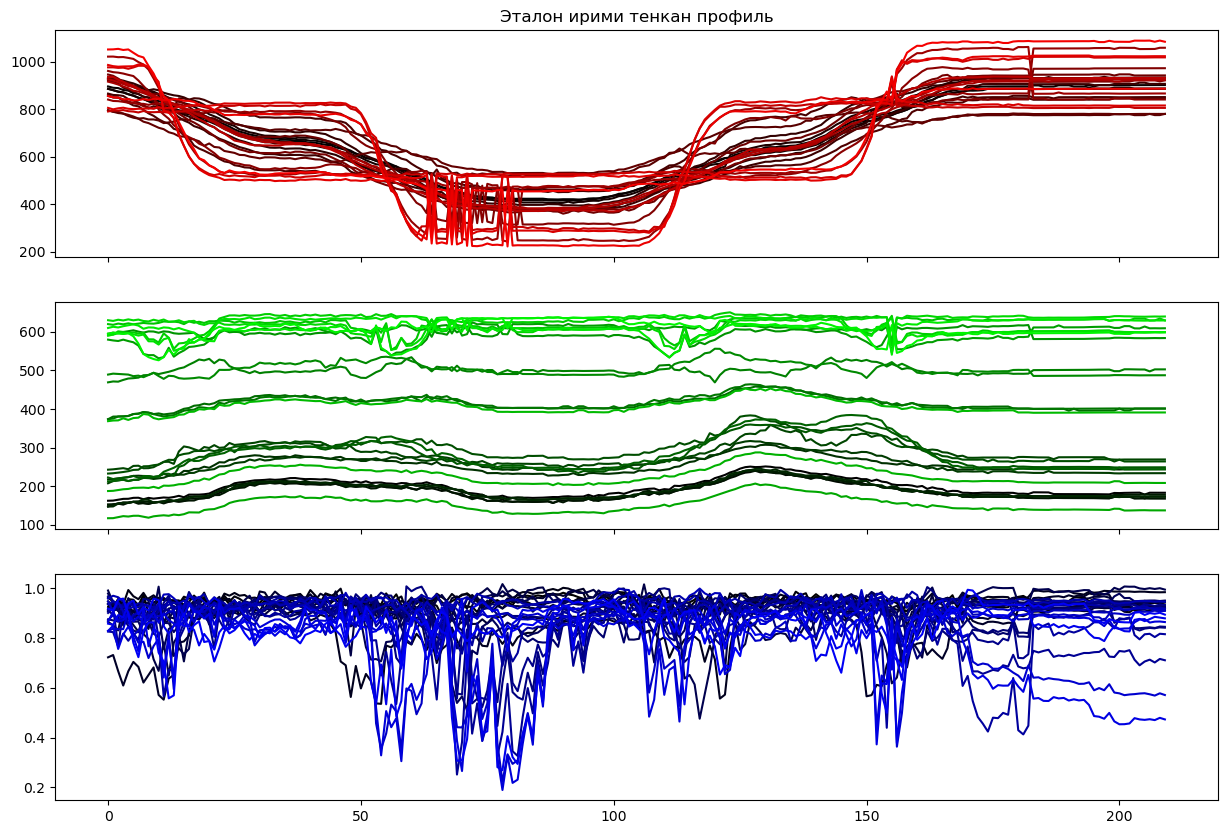

In [22]:
plot_joints_from_json("../alphapose_res/ref_irimi_tenkan_side.json", "Эталон ирими тенкан профиль")

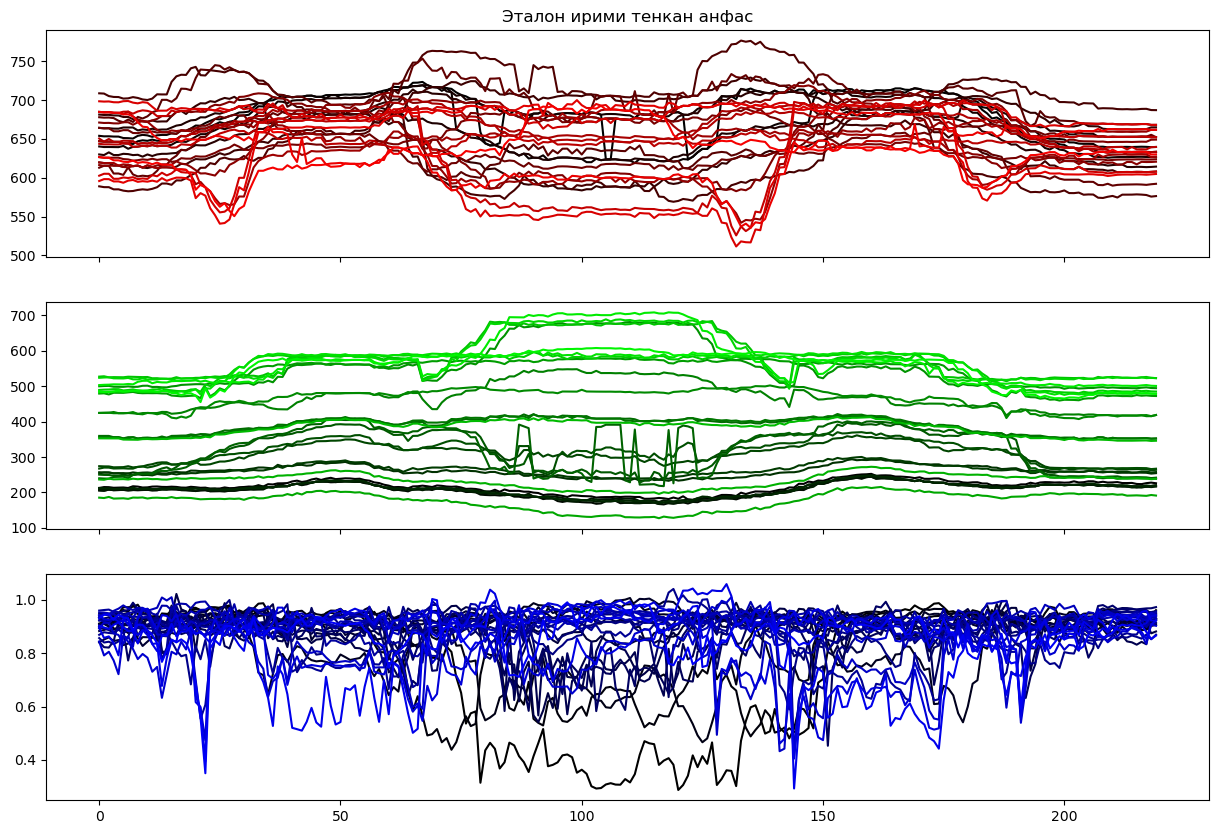

In [21]:
plot_joints_from_json("../alphapose_res/ref_irimi_tenkan_back.json", "Эталон ирими тенкан анфас")#plot_joint_coords_chart("Эталон ирими тенкан анфас", joint_coords)

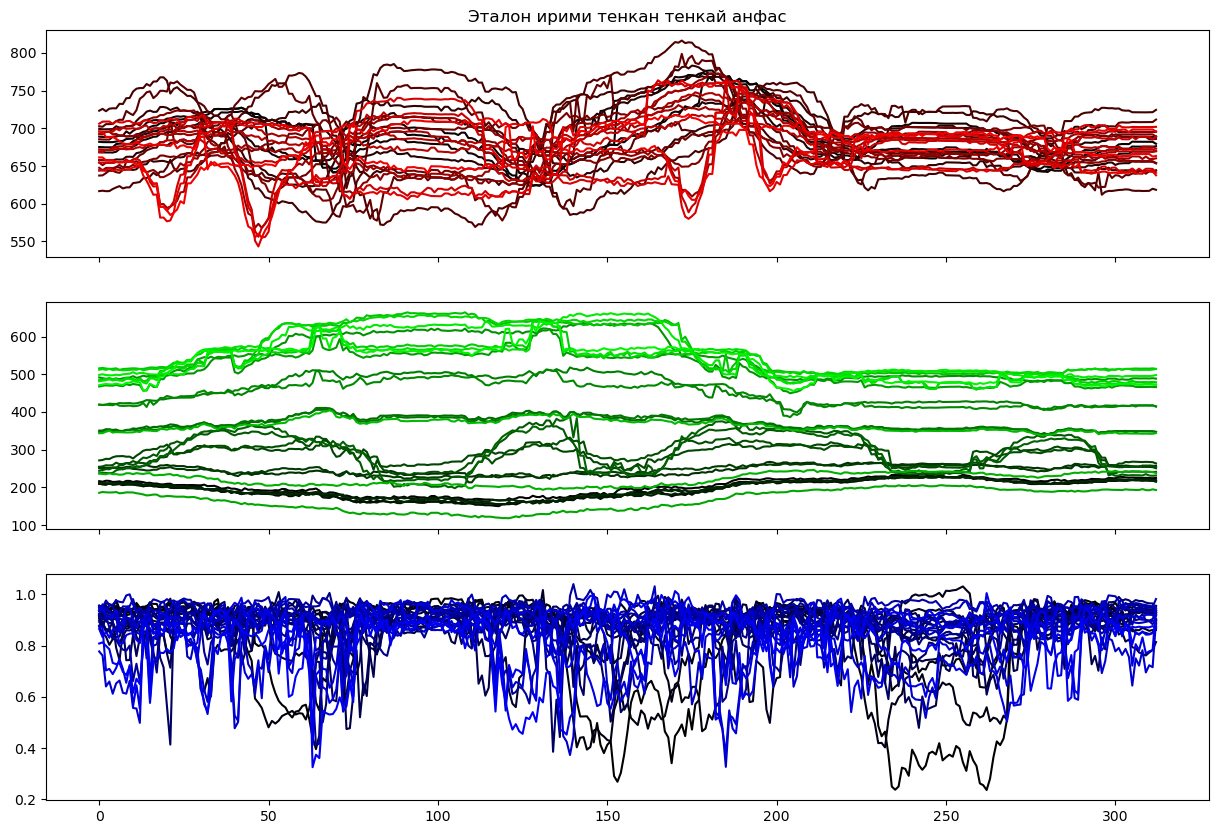

In [23]:
plot_joints_from_json("../alphapose_res/irimi_tenkan_tenkai_back_ref.json", "Эталон ирими тенкан тенкай анфас")

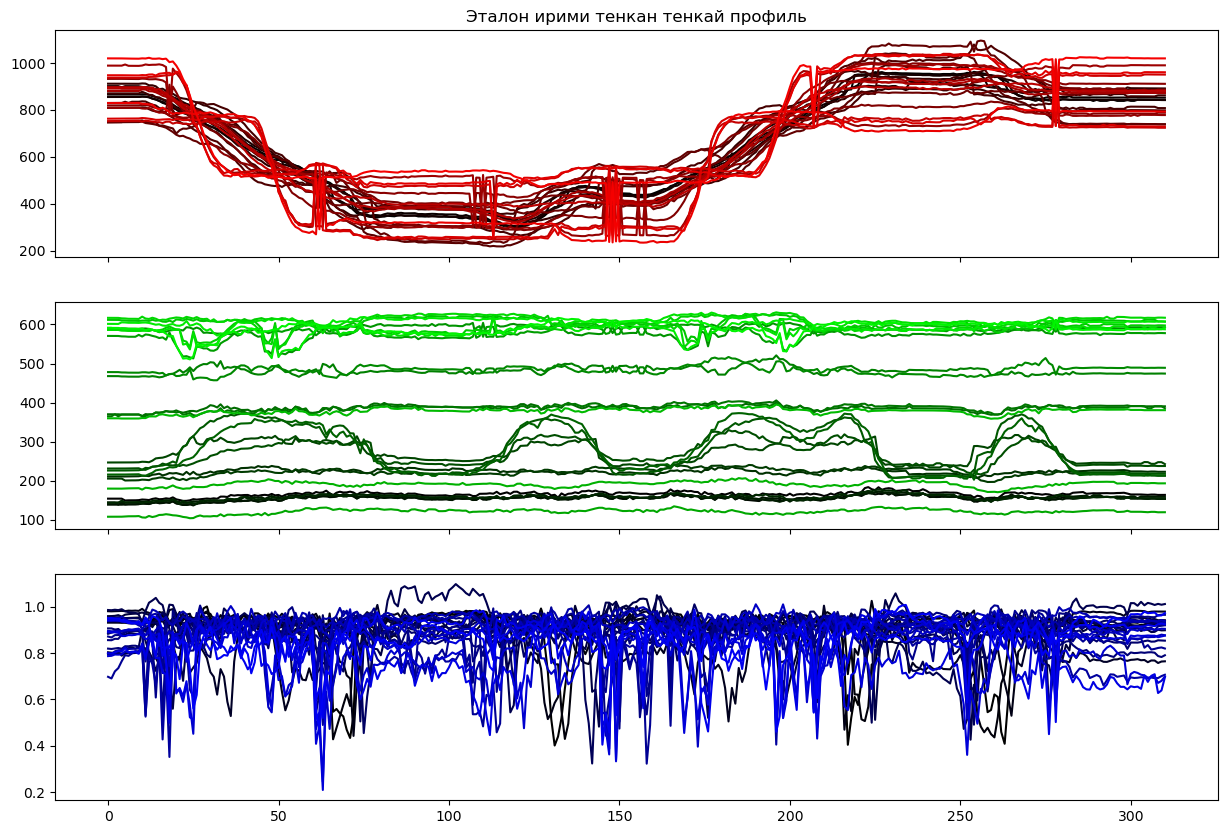

In [24]:
plot_joints_from_json("../alphapose_res/irimi_tenkan_tenkai_side_ref.json", "Эталон ирими тенкан тенкай профиль")

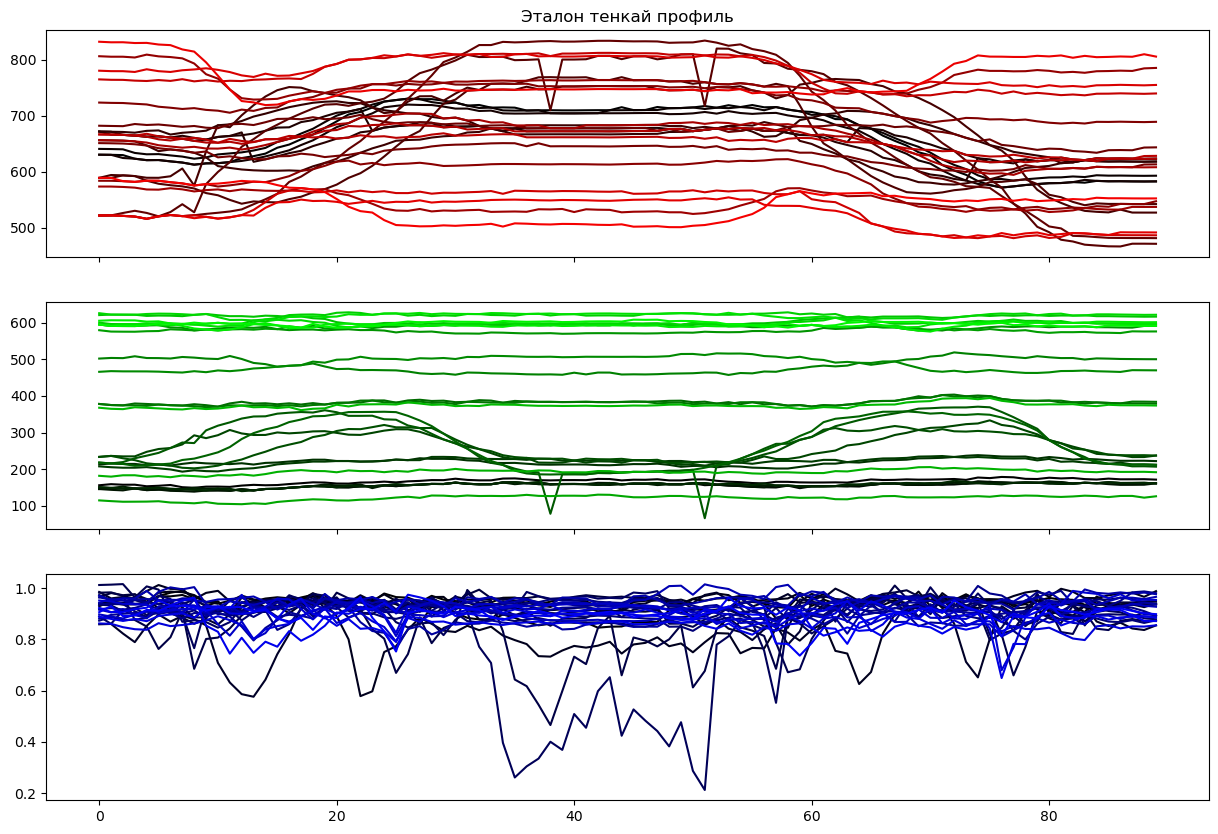

In [25]:
plot_joints_from_json("../alphapose_res/tenkai_side_ref.json", "Эталон тенкай профиль")

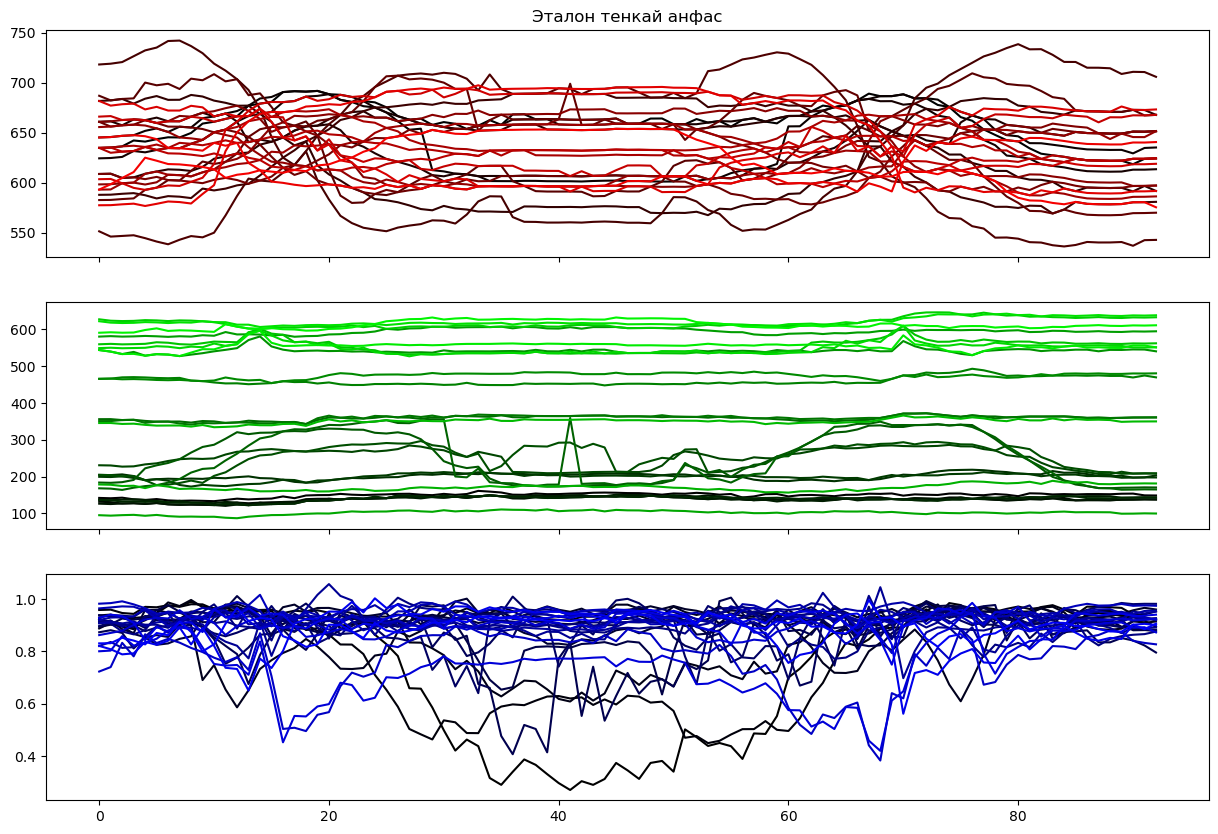

In [26]:
plot_joints_from_json("../alphapose_res/tenkai_back_ref.json", "Эталон тенкай анфас")

# Мой алгоритм трекинга (лучше reid)

In [6]:
with open("../alphapose_res/0756_alpha.json", "r") as res_file:
    kps_info = json.load(res_file)

In [25]:
all_frame_ids = [f["image_id"] for f in kps_info]
uniq_frames, people_count = np.unique(all_frame_ids, return_counts=True)
uniq_people_count, in_frames = np.unique(people_count, return_counts=True)
for pc_v, frame_count in zip(uniq_people_count, in_frames):
    print(pc_v, frame_count)
# количество людей, количество кадров, в которых было подсчитано столько людей

9 3
10 39
11 105
12 334
13 581
14 802
15 786
16 745
17 435
18 145
19 40
20 7
23 1


In [7]:
def bbox_iou(box1, box2):
    #BoundingBox(origin_x, origin_y, width, height)
    xmax1 = box1[0] + box1[2]
    ymax1 = box1[1] + box1[3]
    xmax2 = box2[0] + box2[2]
    ymax2 = box2[1] + box2[3]
    dx = min(xmax1, xmax2) - max(box1[0], box2[0])
    dy = min(ymax1, ymax2) - max(box1[1], box2[1])
    if (dx>=0) and (dy>=0):
        inters = dx*dy
        area1 = box1[2] * box1[3]
        area2 = box2[2] * box2[3]
        percent_coverage = inters / (area1 + area2 - inters)
        return percent_coverage
    return 0

def update_person_box(prev:dict, newly:list, max_box_count:int):
    new_index = dict()
    ious = dict()
    for box in newly:
        potential_index = dict()
        for idx in prev:
            cur_iou = bbox_iou(box, prev[idx])
            if cur_iou <= 1e-4:
                # new_max_idx = max(prev) + 1
                # potential_index[new_max_idx] = 1
                continue
                # if len(prev) < len(newly):
                #     if len(new_index) == 0:
                #         new_max_idx = max(prev) + 1
                #     else:
                #         new_max_idx = max(max(prev), max(new_index)) + 1
                #     new_max_idx = min(new_max_idx, max_box_count-1)
                #     potential_index[new_max_idx] = 1
                # continue
            if idx in new_index and (ious[idx] >= cur_iou):
                continue                
            potential_index[idx] = cur_iou
        if len(potential_index) > 0:
            max_index = max(potential_index, key=potential_index.get)
            new_index[max_index] = box
            ious[max_index] = potential_index[max_index]
        else: # found new person
            new_max_idx = max(prev) + 1
            new_index[new_max_idx] = box
            ious[new_max_idx] = 1
    for idx in prev:
        if not (idx in new_index):
            new_index[idx] = prev[idx]
    return new_index

def vis_box_tracking(image, boxes:dict, colors:np.ndarray) -> np.ndarray:
    for box_key in boxes:
        color = (int(colors[box_key, 0]), int(colors[box_key, 1]), int(colors[box_key, 2]))
        bbox = boxes[box_key]
        start_point = int(bbox[0]), int(bbox[1])
        end_point = int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])
        cv.rectangle(image, start_point, end_point, color, 2)
        text_location = (10 + int(bbox[0]), 20 + int(bbox[1]))
        cv.putText(image, str(box_key), text_location, cv.FONT_HERSHEY_PLAIN, 1, color, 3)
    return image

In [8]:
codec_code = cv.VideoWriter.fourcc(*'h264')
writer = cv.VideoWriter("../0756_box_tracking.mp4", codec_code, 30.0, (1280, 720))
writer.isOpened()

True

In [9]:
vidcap = cv.VideoCapture("../original_vids/0756-30fps.mp4")
fps = vidcap.get(cv.CAP_PROP_FPS)
total_frames = int(vidcap.get(cv.CAP_PROP_FRAME_COUNT))
current_json_entry = 0
boxes_by_frame = dict()
for frame_idx in range(total_frames):
    frame_people = []
    while kps_info[current_json_entry]['image_id'] == frame_idx:
        box = kps_info[current_json_entry]['box']
        frame_people.append(box)
        if current_json_entry + 1 >= len(kps_info): break
        current_json_entry += 1
    boxes_by_frame[frame_idx] = frame_people
    
students_num = 15
colors = np.random.default_rng().integers(0, 256, (1000, 3), dtype='uint8')
sorting_key = lambda b: b[2] * b[3]
frame0boxes_by_area = sorted(boxes_by_frame[0], key=sorting_key, reverse=True)
prev_boxs = dict()
for i, v in enumerate(frame0boxes_by_area):#[:students_num]):
    prev_boxs[i] = v
frame2boxes = {0 : prev_boxs}
success,frame = vidcap.read()
if success:
    annotated_img = vis_box_tracking(frame, prev_boxs, colors)
    writer.write(annotated_img)
for i in tqdm(range(1, total_frames)):
    frame_boxes_by_area = sorted(boxes_by_frame[i], key=sorting_key, reverse=True)
    #topk_boxs = frame_boxes_by_area[:students_num]
    prev_boxs = update_person_box(prev_boxs, frame_boxes_by_area, students_num)
    frame2boxes[i] = prev_boxs
    success,frame = vidcap.read()
    if success:
        annotated_img = vis_box_tracking(frame, prev_boxs, colors)
        writer.write(annotated_img)
vidcap.release() 
writer.release()

100%|█████████████████████████████████████████████████████████████████████████████| 1649/1649 [00:04<00:00, 340.33it/s]


In [ ]:
id2frame_count = dict()
for frame_idx in frame2boxes:
    for person in frame2boxes[frame_idx]:
        if person in id2frame_count:
            id2frame_count[person] += 1
        else:
            id2frame_count[person] = 1
            
auto_tracked_ids2student_ids = {7:0, 6:1, 0:2, 8:3, 1:4, 3:5, 11:6, 15:7,
                               16:8, 2:9, 5:12, 9:13, 4:14} # irimi tenkan

#student_ids = [7, 6, 0, 8, 1, 3, 11, 2, 4, 15, 16, 5, 9] # визуально полученные человеком id
for k in id2frame_count:
    if k in auto_tracked_ids2student_ids:
        print(k, id2frame_count[k], auto_tracked_ids2student_ids[k])
    else:
        print(k, id2frame_count[k])

# Анализ повторений упражнения

In [18]:
track_id2student_id_it = {7:0, 6:1, 0:2, 8:3, 1:4, 3:5, 11:6, 15:7, 16:8, 2:9, 5:12, 9:13, 4:14} # irimi tenkan, my tracking algo
track_id2student_id_ta = {8:0, 7:1, 2:2, 10:3, 3:4, 4:5, 14:6, 9:7, 1:8, 12:9, 11:10, 0:11, 6:12, 5:13} # tsugi ashi, my tracking algo
track_id2student_id_utmt = {7:0, 6:1, 1:2, 8:3, 3:4, 5:5, 11:6, 10:7, 2:8, 0:11, 4:13, 9:9, 12:10, 19:12} # utmt, my tracking algo

In [50]:
with open("../alphapose_res/irimi_tenkan_kps.json", "r") as res_file:
    kps_info = json.load(res_file)

In [38]:
total_frames = kps_info[-1]["image_id"] + 1 
current_json_entry = 0
boxes_by_frame = dict()
for frame_idx in range(total_frames):
    frame_people = []
    while kps_info[current_json_entry]['image_id'] == frame_idx:
        box = kps_info[current_json_entry]['box']
        frame_people.append(box)
        if current_json_entry + 1 >= len(kps_info): break
        current_json_entry += 1
    boxes_by_frame[frame_idx] = frame_people
    
sorting_key = lambda b: b[2] * b[3]
#sorted_inds, frame0boxes_by_area = zip(*sorted([(i,e) for i,e in enumerate(boxes_by_frame[0])], key=sorting_key))
frame0boxes_by_area = sorted(boxes_by_frame[0], key=sorting_key, reverse=True)
prev_boxs = dict()
for i, v in enumerate(frame0boxes_by_area):#[:students_num]):
    prev_boxs[i] = v
frame2boxes = {0 : prev_boxs}
# success,frame = vidcap.read()
# if success:
#     annotated_img = vis_box_tracking(frame, prev_boxs, colors)
#     writer.write(annotated_img)
for i in tqdm(range(1, total_frames)):
    frame_boxes_by_area = sorted(boxes_by_frame[i], key=sorting_key, reverse=True)
    #topk_boxs = frame_boxes_by_area[:students_num]
    prev_boxs = update_person_box(prev_boxs, frame_boxes_by_area, students_num)
    frame2boxes[i] = prev_boxs

100%|███████████████████████████████████████████████████████████████████████████████| 854/854 [00:02<00:00, 325.80it/s]


In [ ]:
json_entry_count = 0
for fid in tqdm(frame2boxes):
    boxes = frame2boxes[fid]
    # get entries
    frame_entries = []
    while kps_info[json_entry_count]["image_id"] == fid:
        frame_entries.append(kps_info[json_entry_count])
        json_entry_count += 1    
    for entry in frame_entries: 
        for det_id in boxes:
            if not det_id in track_id2student_id_it: 
                student_id = -1
            else:
                student_id = track_id2student_id_it[det_id]
            box = boxes[det_id]            
            entbox = entry["box"]
            if entbox[0] != box[0]: continue # bad coding
            if entbox[1] != box[1]: continue
            if entbox[2] != box[2]: continue
            if entbox[3] != box[3]: continue
            entry["idx"][0] = student_id

In [86]:
studentids = set(track_id2student_id_it.values())
max_frame_count = kps_info[-1]["image_id"] + 1
studentid2dynamic = dict()
for k in studentids:
    studentid2dynamic[k] = []
for entry in kps_info:
    try:
        if entry["idx"][0] in studentid2dynamic:
            studentid2dynamic[entry["idx"][0]].append(entry)
    except TypeError:
        pass

sid2kps = dict()
for student_id in studentid2dynamic:
    dynamic_info = studentid2dynamic[student_id]
    cur_student_kps = [[] for i in range(26)]
    prev_frame = 0
    if dynamic_info[0]["image_id"] > prev_frame:
        while prev_frame < dynamic_info[0]["image_id"]:
            for jlist in cur_student_kps:
                jlist.append([0, 0, 0])
            prev_frame += 1
    for pose in dynamic_info:
        if (pose['image_id'] - prev_frame) > 1:
            stop_frame = pose['image_id'] - 1
            while prev_frame < stop_frame:
                for jlist in cur_student_kps:
                    jlist.append([0, 0, 0])
                prev_frame += 1
        pps = pose["keypoints"]
        for jidx, jlist in enumerate(cur_student_kps):
            x = (pps[jidx*3] - pose['box'][0]) / float(pose['box'][2])
            y = (pps[1 + jidx*3] - pose['box'][1]) / float(pose['box'][3])
            conf = pps[2 + jidx*3]
            jlist.append([x, y, conf])
        prev_frame = pose['image_id']
    joints_array = np.array(cur_student_kps)
    if joints_array.shape[1] < max_frame_count:
        add_fr = max_frame_count - joints_array.shape[1]
        addition = np.zeros((joints_array.shape[0], add_fr, joints_array.shape[2]))
        joints_array = np.concatenate((joints_array, addition), axis=1)
    elif joints_array.shape[1] > max_frame_count:
        joints_array = joints_array[:, :max_frame_count, :]
    sid2kps[student_id] = joints_array
        
for sid in sid2kps:
    print(sid2kps[sid].shape)

(26, 855, 3)
(26, 855, 3)
(26, 855, 3)
(26, 855, 3)
(26, 855, 3)
(26, 855, 3)
(26, 855, 3)
(26, 855, 3)
(26, 855, 3)
(26, 855, 3)
(26, 855, 3)
(26, 855, 3)
(26, 855, 3)


In [87]:
# normalization
for sid in sid2kps:
    old_ar = sid2kps[sid]
    for chid in range(old_ar.shape[2]):
        old_ar[:, :, chid] = (old_ar[:, :, chid] - old_ar[:, :, chid].min()) \
                              / (old_ar[:, :, chid].max() - old_ar[:, :, chid].min())
for sid in sid2kps:
    print(np.max(sid2kps[sid][:, :, 2]), np.min(sid2kps[sid][:, :, 2]))   

1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0


2024-01-31 16:19:35 [DEBUG]: Loaded backend module://matplotlib_inline.backend_inline version unknown.


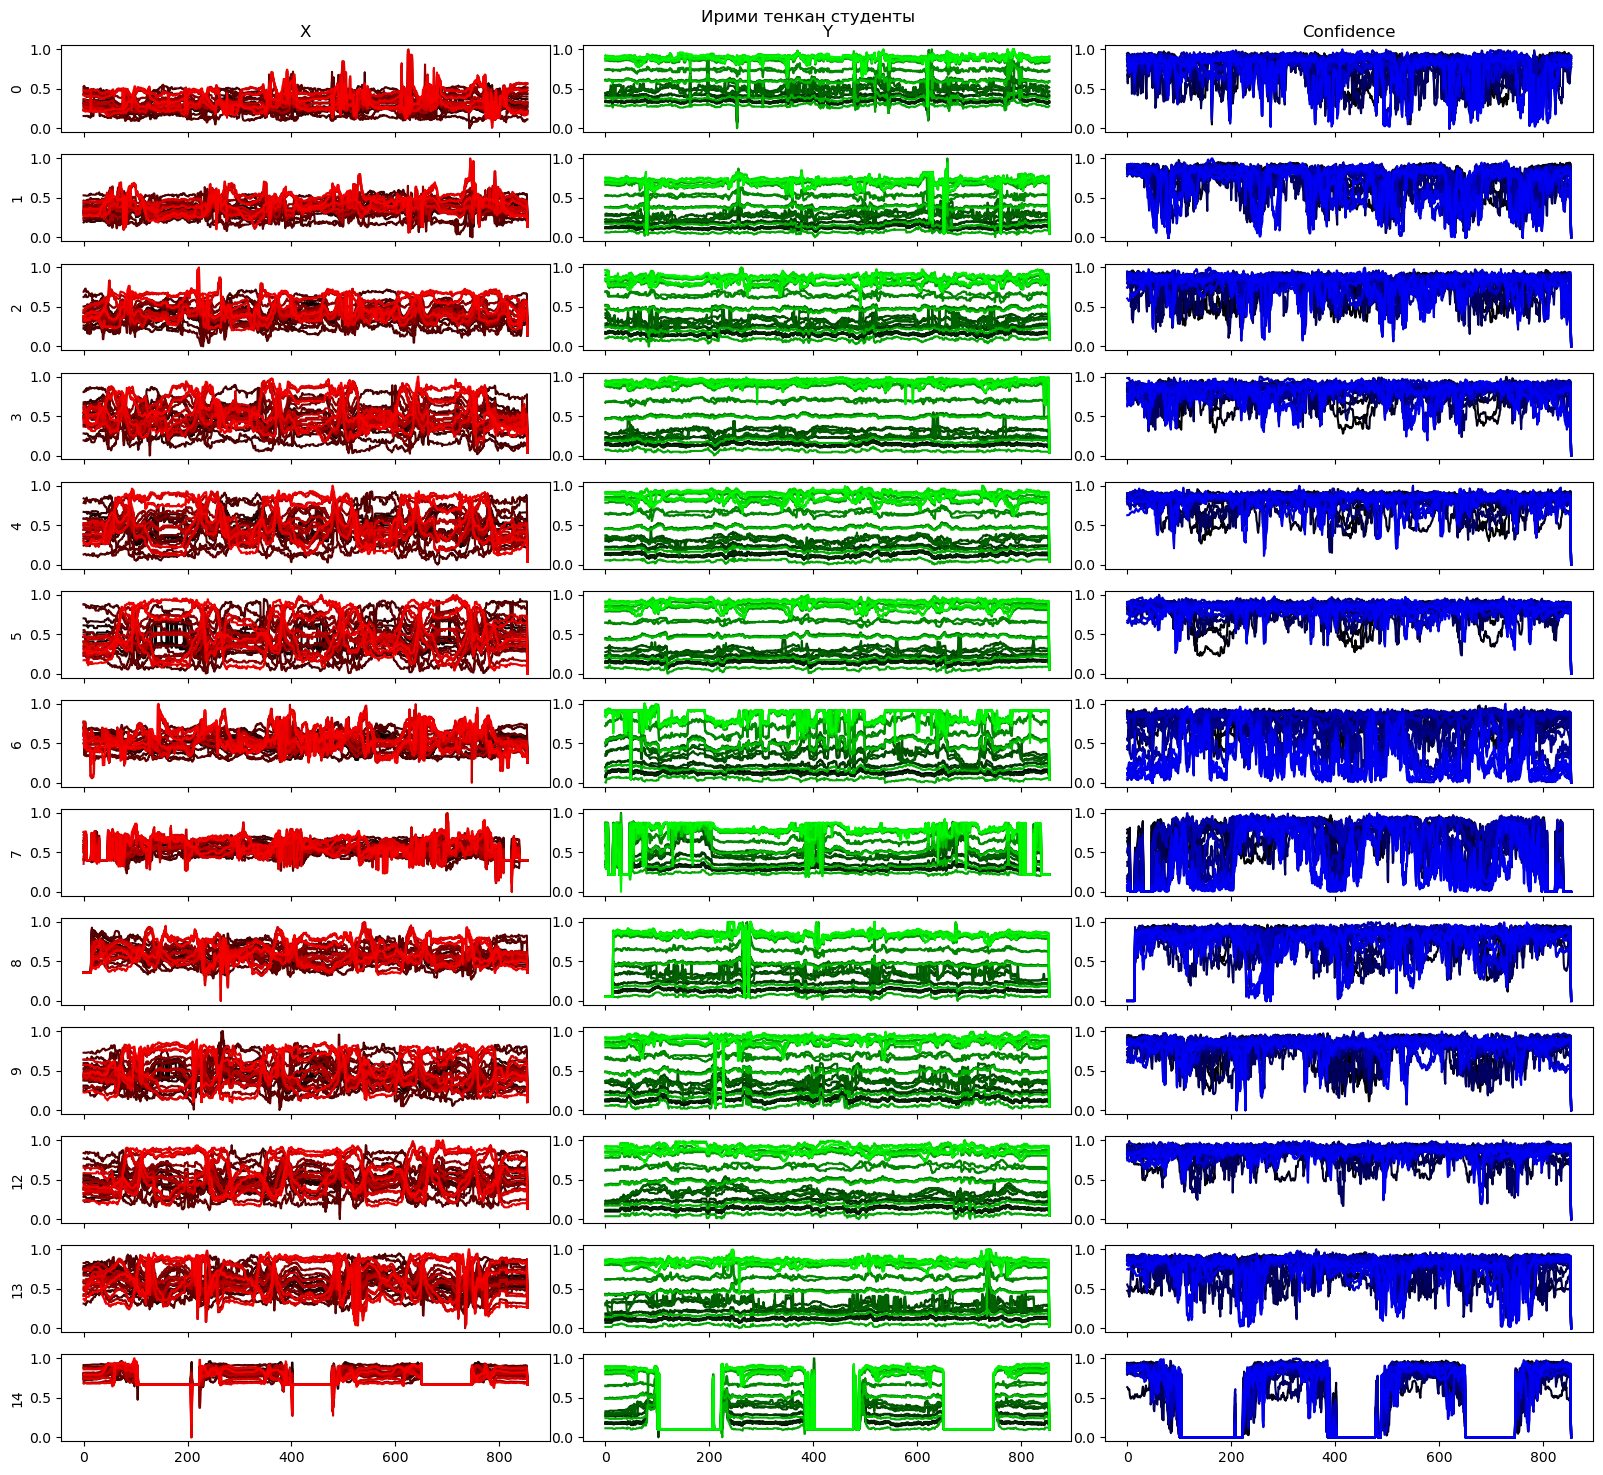

In [97]:
%matplotlib inline
def plot_students_one(max_frame_count:int, sid2kps:dict, title:str):
    x_data = np.arange(max_frame_count)
    fig, axs = plt.subplots(len(sid2kps), 3, sharex=True, figsize=(16, 15))
    joint_count = sid2kps[0].shape[0]
    color_step = 255 / joint_count
    for count, idx in enumerate(sid2kps):
        for i in range(joint_count):
            clr = color_step * i / 255
            axs[count, 0].plot(x_data, sid2kps[idx][i, :, 0], color=(clr, 0, 0))
            axs[count, 1].plot(x_data, sid2kps[idx][i, :, 1], color=(0, clr, 0))
            axs[count, 2].plot(x_data, sid2kps[idx][i, :, 2], color=(0, 0, clr))
            axs[count, 0].set_ylabel(idx)
    axs[0, 0].set_title("X")
    axs[0, 1].set_title("Y")
    axs[0, 2].set_title("Confidence")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
plot_students_one(max_frame_count, sid2kps, "Ирими тенкан студенты")
# в строке - графики координат и confidence одного ученика, id ученика слева

# Визуализация reid трекинга

In [8]:
with open("../alphapose_res/selection_192815_reid.json") as ann_file:
    auto_track_anns = json.load(ann_file)

In [ ]:
ids = [f["idx"] for f in auto_track_anns]
uniqs, uniqs_counts = np.unique(ids, return_counts=True)
for uv, vc in zip(uniqs, uniqs_counts):
    print(uv, vc)

In [15]:
# vis auto tracking
codec_code = cv.VideoWriter.fourcc(*'h264')
writer = cv.VideoWriter("../selection_192815_check_reid.mp4", codec_code, 30.0, (1280, 720))
print(writer.isOpened())

True


In [16]:
vidcap = cv.VideoCapture("../original_vids/selection_20240214_192815-30fps.mp4")
fps = vidcap.get(cv.CAP_PROP_FPS)
total_frames = int(vidcap.get(cv.CAP_PROP_FRAME_COUNT))
colors = np.random.default_rng().integers(0, 256, (1000, 3), dtype='uint8')

current_frame = 0
success,frame = vidcap.read()
boxes = dict()
for record in auto_track_anns:
    if record['image_id'] == (current_frame + 1):
        annotated_img = vis_box_tracking(frame, boxes, colors)
        writer.write(annotated_img)
        boxes.clear()
        success,frame = vidcap.read()
        if not success: 
            break
        current_frame += 1
    person_id = record['idx'] - 1
    pbox = record["box"]
    boxes[person_id] = pbox
vidcap.release() 
writer.release()